In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
filepath = '../data/cell_tracks/'

## This is the preprocessing pipeline for both the macrophage cell tracks 
The below code should preprocess the data before it is ready to be run in the inference pipeline. It does this by the following steps:
1. Loads the csv files holding the cell tracking data
2. Cleans the data on the quality of the cell tracks 
3. Cleans the data dependent on the average length of the cell tracks (i.e. how may timepoints they have)
4. Removes any cell tracks which are outside of the main body of the pupae of the fly 
7. Saves a new csv file which contains the filtered cell tracks for later use in inference pipeline  


In [2]:
# load Macrophage cell tracks
# Control 
df_c1 = pd.read_csv(filepath+'Single_wound/CTR_revision/20240507   Post-W CONTROL  001_Maximum intensity projection_Tracks.csv')  
df_c2 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240508  Post-W CONTROL  003_Maximum intensity projection_Tracks.csv')  
df_c3 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240508  Post-W CONTROL  004_Maximum intensity projection_Tracks.csv') 
df_c4 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240509  Post-W CONTROL  006_Maximum intensity projection_Tracks.csv') 
df_c5 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240510  Post-W CONTROL  007_Maximum intensity projection_Tracks.csv') 
df_c6 = pd.read_csv(filepath+'Single_wound/CTR_revision/C2-20240510  Post-W CONTROL  008_Maximum intensity projection_Tracks.csv') 

# MCR 
df_mcr1 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240424  Post-W MCR  004_Maximum intensity projection_Tracks.csv')
df_mcr2 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240430  Post-W MCR  005_Maximum intensity projection_Tracks.csv')
df_mcr3 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240502  Post-W MCR  008_Maximum intensity projection_Tracks.csv')
df_mcr4 = pd.read_csv(filepath+'Single_wound/MCR_revision/20240503  Post-W MCR  009_Maximum intensity projection_Tracks.csv')
# df_mcr5 = pd.read_csv(filepath+'Single_wound/MCR_revision/C2-20240424  Post-W MCR  003_Maximum intensity projection_Tracks.csv')

In [3]:
#list of data frames
list_dfs = [df_c1, df_c2, df_c3, df_c4, df_c5, df_c6, df_mcr1, df_mcr2, df_mcr3, df_mcr4]#, df_mcr5]# single wound

list_dflabels = ["c1", "c2", "c3", "c4", "c5", "c6", "mcr1", "mcr2", "mcr3", "mcr4"]#, "mcr5"]# single wound

list_woundlocs = [(204, 321), (229, 315), (208, 339), (180, 289), (180, 291), (206, 295),# single wound CTR
                  (184, 326), (191, 291), (225, 329), (194, 320)]#, (183, 331)] # single wound MCR
# convert pixel units to microns
pixels2microns = 1.107
list_woundlocs = [(a*pixels2microns, b*pixels2microns) for a, b in list_woundlocs]

In [4]:
list_woundlocs

[(225.828, 355.347),
 (253.503, 348.705),
 (230.256, 375.27299999999997),
 (199.26, 319.923),
 (199.26, 322.137),
 (228.042, 326.565),
 (203.688, 360.882),
 (211.43699999999998, 322.137),
 (249.075, 364.203),
 (214.758, 354.24)]

In [5]:
# count number of unique tracks
for i, this_df in enumerate(list_dfs):
    print(i, list_dflabels[i], this_df['/particle/#id'].nunique())

0 c1 302
1 c2 294
2 c3 398
3 c4 270
4 c5 269
5 c6 330
6 mcr1 432
7 mcr2 315
8 mcr3 318
9 mcr4 317


In [6]:
# Preprocessing dataframe to make it cleaner to use 
def preprocess(df):
    df.drop(['/@frameInterval/#agg','/@from','/@nTracks/#agg','/@generationDateTime','/particle/detection/@z'], axis = 1, inplace = True)
    df.rename(columns={'/particle/#id': 'Track_ID',
                        '/particle/detection/@t': 't',
                        '/particle/detection/@x': 'x',
                        '/particle/detection/@y': 'y'}, inplace = True)
    return df # not needed if modified in place

# This function takes in our new dataframe without the FBC linked tracks, cleans up the labelling of the columns and renormalises the tracks so the wound is at 0,0. It also adds a label to the 
# Track_ID so we can keep track of which track belongs to which original dataframe. This is important for running the inference pipeline later. 
def centre_at_zero(df,xw,yw,label):  
    df['x'] = df['x'] - xw
    df['y'] = df['y'] - yw
    df['r'] = (lambda x, y: np.sqrt(x ** 2 + y ** 2))(df['x'], df['y'])
    theta = -np.pi / 4
    rotation_matrix = np.array([[np.cos(theta), np.sin(theta)],
                            [-np.sin(theta), np.cos(theta)]])

    # Apply the rotation to the DataFrame
    rotated_coordinates = np.dot(df[['x', 'y']], rotation_matrix.T)

    # Update the DataFrame with rotated coordinates
    df[['rotate-x', 'rotate-y']] = rotated_coordinates
    df['theta'] = np.arctan2(df['rotate-y'], df['rotate-x'])

    df['Track_ID'] = df['Track_ID'].astype(str)
    df.Track_ID = df.Track_ID + "{}".format(label)  # creates a label for the tracks to be organised by
    return df

In [7]:
list_dfs_filtered = []
for i, this_df in enumerate(list_dfs):
    filtered_df = preprocess(this_df)
    # adjust y position to Python standard from ImageJ 
    filtered_df['y'] = 565.688 - filtered_df['y'] 
    # Reset times to minutes
    filtered_df['t'] = filtered_df['t']*filtered_df['/@frameInterval'].div(60)
    # centre with respect to wound location
    if isinstance(list_woundlocs[i][0], int) or isinstance(list_woundlocs[i][0], float): #single wound
        filtered_df = centre_at_zero(filtered_df,list_woundlocs[i][0], 565.688-list_woundlocs[i][1], '_'+list_dflabels[i])
    elif isinstance(list_woundlocs[i][0], tuple): #two wounds
        midpoint_btw_wounds = np.mean(list_woundlocs[i], axis=0)
        filtered_df = centre_at_zero(filtered_df,midpoint_btw_wounds[0], 565.688-midpoint_btw_wounds[1], '_'+list_dflabels[i])
    list_dfs_filtered.append(filtered_df)

In [8]:
list_dfs_filtered[0]

,/@frameInterval,/@nTracks,/@spaceUnits,/@timeUnits,/particle/@nSpots,Track_ID,t,x,y,r,rotate-x,rotate-y,theta
0,29.929583,302,micron,sec,45,1_c1,0.000000,282.365138,-158.504439,323.811254,311.741868,87.582740,0.273886
1,29.929583,302,micron,sec,45,1_c1,0.498826,282.529024,-158.781968,324.090053,312.053995,87.502382,0.273387
2,29.929583,302,micron,sec,45,1_c1,0.997653,282.048413,-159.121442,323.837831,311.954196,86.922495,0.271746
3,29.929583,302,micron,sec,45,1_c1,1.496479,281.994471,-158.661848,323.565239,311.591072,87.209334,0.272901
4,29.929583,302,micron,sec,45,1_c1,1.995306,282.018673,-159.676425,324.085009,312.325599,86.509034,0.270209
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13069,29.929583,302,micron,sec,6,301_c1,23.943666,15.256873,-0.791235,15.277377,11.347726,10.228751,0.733584
13070,29.929583,302,micron,sec,6,301_c1,24.442492,13.974205,-0.512170,13.983588,10.243414,9.519096,0.748763
13071,29.929583,302,micron,sec,6,301_c1,24.941319,14.218674,0.130675,14.219274,9.961719,10.146522,0.794588
13072,29.929583,302,micron,sec,2,302_c1,24.442492,-76.041317,7.660353,76.426193,-59.186019,-48.352643,-2.456595


In [9]:
# list_dflabels = ["c1", "c2", "c3", "c4", "c5", "c6", "mcr1", "mcr2", "mcr3", "mcr4", "mcr5"]# single wound
list_dflabels[6:]

['mcr1', 'mcr2', 'mcr3', 'mcr4']

In [10]:
# Save the data to csv for processing the Inference pipeline
singlewound_control_data = pd.concat(list_dfs_filtered[0:6]).reset_index()
singlewound_control_data.to_csv(filepath+'Single_wound/CTR_revision/Control_filtered_combined.csv')

singlewound_mcr_data = pd.concat(list_dfs_filtered[6:]).reset_index()
singlewound_mcr_data.to_csv(filepath+'Single_wound/MCR_revision/MCR_filtered_combined.csv')

# halfwound_data = pd.concat(list_dfs_filtered[10:14]).reset_index()
# # halfwound_data.to_csv(filepath+'Half_wound/Halfwound_filtered_combined')

# twowound_control_data = pd.concat(list_dfs_filtered[14:17]).reset_index()
# # twowound_control_data.to_csv(filepath+'Two_wound_data/Control/Two_wound_Control_filtered_combined')

# twowound_mcr_data = pd.concat(list_dfs_filtered[17:21]).reset_index()
# # twowound_mcr_data.to_csv(filepath+'Two_wound_data/MCR/Two_wound_MCR_filtered_combined')

## Plots the cell tracks 

Plot the cell tracks to make sure they are orientated the correct way and with good coverage for the inference 

In [11]:
from matplotlib.patches import Circle

def plot_cell_tracks_and_stats(cellTracks, savefilename, woundradius=37.3):
    # Pre-compute x and y coordinates grouped by Track_ID
    grouped = cellTracks.groupby('Track_ID')
    track_durations = grouped.size().values
    start_positions = grouped[['x', 'y']].first().values
    end_positions = grouped[['x', 'y']].last().values
    trackDistances = np.linalg.norm(start_positions - end_positions, axis=1)
    # calculate the distance from wound for all coordinates
    cellTracks['r'] = (lambda x, y: np.sqrt(x ** 2 + y ** 2))(cellTracks['x'], cellTracks['y'])

    fig, ax = plt.subplots(2, 2, figsize=(15, 15))

    # Plot all tracks
    for name, group in grouped:
        ax[0,0].plot(group['x'], group['y'], alpha=0.4)

    # Add circle patch
    circ1 = Circle((0, 0), 34, facecolor='None', edgecolor='k', lw=3, alpha=1)
    ax[0,0].add_patch(circ1)
    ax[0,0].set_xlabel('X Position ($\mu$m)')
    ax[0,0].set_ylabel('Y Position ($\mu$m)')

    # Plot 2D histogram of time and radius
    hist2d_rt = ax[0,1].hist2d(cellTracks['r'], cellTracks['t'], bins=(50, 51), cmap='Greys')
    plt.colorbar(hist2d_rt[3], ax=ax[0,1], label='Number of spots')
    # add a dashed line to show the wound radius
    ax[0,1].plot([woundradius, woundradius], [0, 25], 'r--', lw=2)
    ax[0,1].set_ylabel('Time (min)')
    ax[0,1].set_xlabel('Distance from wound centre ($\mu$m)')
    ax[0,1].set_xlim(0, 500)

    # Plot 2D histogram of track durations and lengths
    hist2d_qc = ax[1,0].hist2d(track_durations, trackDistances, bins=(5, 10), cmap='Greys')
    plt.colorbar(hist2d_qc[3], ax=ax[1,0], label='Number of tracks')
    ax[1,0].set_xlabel('Track Duration (number of frames)')
    ax[1,0].set_ylabel('Track end-to-end Distance ($\mu$m)')

    # # Plot 2D histogram of track end-to-end distance vs distance to wound
    # hist2d_rl = ax[1,1].hist2d(np.linalg.norm(start_positions, axis=1), trackDistances, bins=(10, 10), cmap='Greys')
    # plt.colorbar(hist2d_rl[3], ax=ax[1,1], label='Number of tracks')
    # ax[1,1].plot([woundradius, woundradius], [0, 90], 'r--', lw=2)
    # ax[1,1].set_ylabel('Track end-to-end Distance ($\mu$m)')
    # ax[1,1].set_xlabel('Distance from wound centre ($\mu$m)')
    # ax[1,1].set_xlim(0, 500)

    # Plot 1D histogram of track end-to-end distance
    hist1d_l = ax[1,1].hist(trackDistances, bins=np.linspace(0,90,10))
    ax[1,1].set_xlabel('Track end-to-end Distance ($\mu$m)')

    plt.savefig(savefilename)
    plt.show()

In [13]:
grouped_test = singlewound_control_data.groupby('Track_ID')

In [14]:
start_positions = grouped_test[['x', 'y']].first().values
end_positions = grouped_test[['x', 'y']].last().values
track_e2e_distances = np.linalg.norm(start_positions - end_positions, axis=1)

In [27]:
tracks_to_exclude = track_e2e_distances < 10
singlewound_control_data.Track_ID.unique()

array(['1_c1', '2_c1', '3_c1', ..., '328_c6', '329_c6', '330_c6'],
      dtype=object)

In [28]:
for name, group in grouped_test:
    print(name)

100_c1
100_c2
100_c3
100_c4
100_c5
100_c6
101_c1
101_c2
101_c3
101_c4
101_c5
101_c6
102_c1
102_c2
102_c3
102_c4
102_c5
102_c6
103_c1
103_c2
103_c3
103_c4
103_c5
103_c6
104_c1
104_c2
104_c3
104_c4
104_c5
104_c6
105_c1
105_c2
105_c3
105_c4
105_c5
105_c6
106_c1
106_c2
106_c3
106_c4
106_c5
106_c6
107_c1
107_c2
107_c3
107_c4
107_c5
107_c6
108_c1
108_c2
108_c3
108_c4
108_c5
108_c6
109_c1
109_c2
109_c3
109_c4
109_c5
109_c6
10_c1
10_c2
10_c3
10_c4
10_c5
10_c6
110_c1
110_c2
110_c3
110_c4
110_c5
110_c6
111_c1
111_c2
111_c3
111_c4
111_c5
111_c6
112_c1
112_c2
112_c3
112_c4
112_c5
112_c6
113_c1
113_c2
113_c3
113_c4
113_c5
113_c6
114_c1
114_c2
114_c3
114_c4
114_c5
114_c6
115_c1
115_c2
115_c3
115_c4
115_c5
115_c6
116_c1
116_c2
116_c3
116_c4
116_c5
116_c6
117_c1
117_c2
117_c3
117_c4
117_c5
117_c6
118_c1
118_c2
118_c3
118_c4
118_c5
118_c6
119_c1
119_c2
119_c3
119_c4
119_c5
119_c6
11_c1
11_c2
11_c3
11_c4
11_c5
11_c6
120_c1
120_c2
120_c3
120_c4
120_c5
120_c6
121_c1
121_c2
121_c3
121_c4
121_c5
121_c6
122_

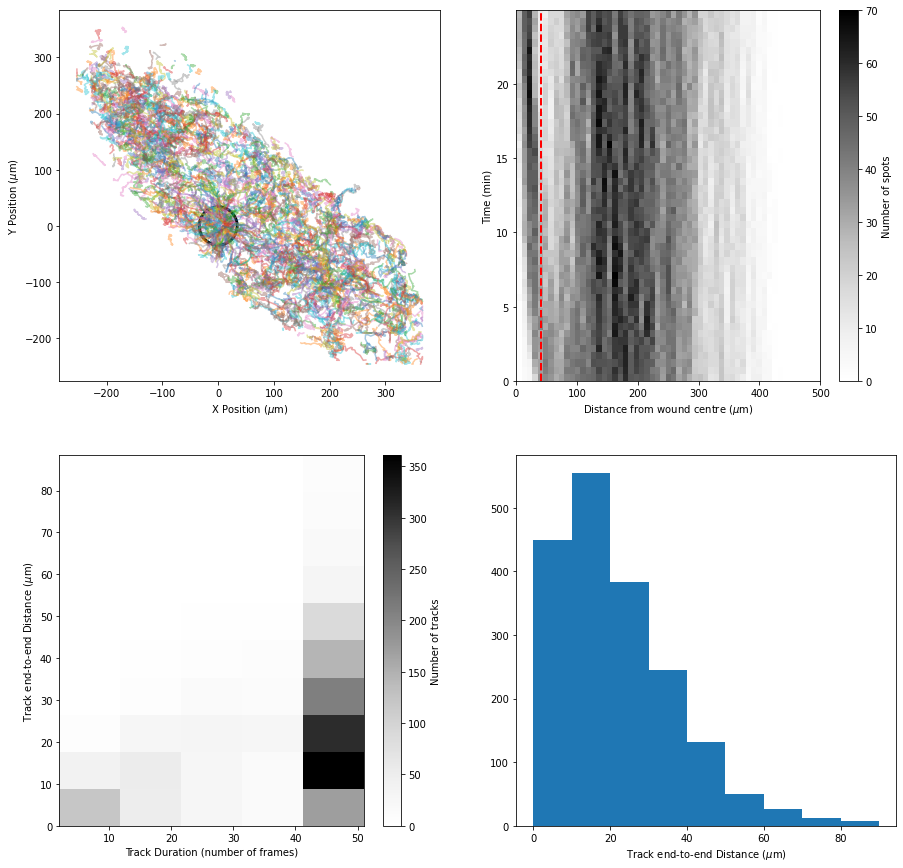

In [ ]:
plot_cell_tracks_and_stats(singlewound_control_data,"Control Cell tracking.pdf", woundradius=41)

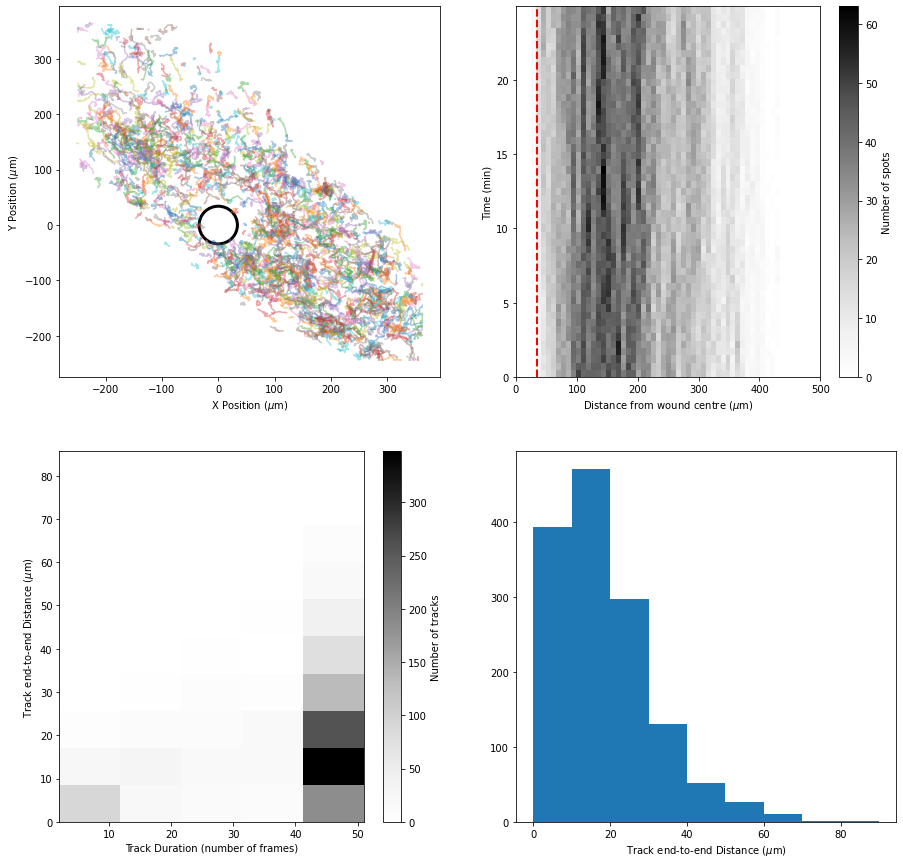

In [ ]:
plot_cell_tracks_and_stats(singlewound_mcr_data,"MCR Cell tracking.pdf", woundradius=34)

In [ ]:
def angle_binning(trajectory):
        theta_pos = trajectory[(trajectory['theta'] >= 0)]
        theta_neg = trajectory[(trajectory['theta'] < 0)]

        return [theta_pos, theta_neg]

def angle_binning2(trajectory):
        theta_pos = trajectory[(trajectory['theta'] >= np.pi/4) & (trajectory['theta'] <= np.pi*3/4)]
        theta_neg = trajectory[(trajectory['theta'] <= - np.pi/4) & (trajectory['theta'] >= - np.pi*3/4)]

        return [theta_pos, theta_neg]

In [ ]:
# angles = angle_binning(halfwound_data)
# angles2 = angle_binning2(halfwound_data)

In [ ]:
# fig, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20, 10))
# for track_id in angles[0]['Track_ID'].unique():
#     # get the x and y coordinates for the current track
#     x = halfwound_data[halfwound_data['Track_ID'] == track_id]['x']
#     y = halfwound_data[halfwound_data['Track_ID'] == track_id]['y']
#     # plot the track as a line
#     ax[0].plot(x, y)
# for track_id in angles2[0]['Track_ID'].unique():
#     # get the x and y coordinates for the current track
#     x = halfwound_data[halfwound_data['Track_ID'] == track_id]['x']
#     y = halfwound_data[halfwound_data['Track_ID'] == track_id]['y']
#     # plot the track as a line
#     ax[1].plot(x, y)
# # add axis labels and legend
# circ1 = Circle((0,0), 30, facecolor='None', edgecolor='k', lw=3, alpha = 1)
# ax[0].add_patch(circ1)
# ax[0].set_xlabel('X Position')
# ax[0].set_ylabel('Y Position')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20, 10))
# for track_id in angles[1]['Track_ID'].unique():
#     # get the x and y coordinates for the current track
#     x = halfwound_data[halfwound_data['Track_ID'] == track_id]['x']
#     y = halfwound_data[halfwound_data['Track_ID'] == track_id]['y']
#     # plot the track as a line
#     ax[0].plot(x, y)
# for track_id in angles2[1]['Track_ID'].unique():
#     # get the x and y coordinates for the current track
#     x = halfwound_data[halfwound_data['Track_ID'] == track_id]['x']
#     y = halfwound_data[halfwound_data['Track_ID'] == track_id]['y']
#     # plot the track as a line
#     ax[1].plot(x, y)
# # add axis labels and legend
# circ1 = Circle((0,0), 30, facecolor='None', edgecolor='k', lw=3, alpha = 1)
# ax[0].add_patch(circ1)
# ax[0].set_xlabel('X Position')
# ax[0].set_ylabel('Y Position')
# plt.show()